# **Deep Learning Project: Distracted Driver Detection** #

This notebook focuses on a **Kaggle** competition  called: **_"State Farm Distracted Driver Detection_"**. It was launched in May 2016 and ended in August 2016.<br>
Details about this competition can be found __[here](https://www.kaggle.com/c/state-farm-distracted-driver-detection)__. The main objective was the following:<br>
> _"Given a dataset of 2D dashboard camera images, State Farm is challenging Kagglers to classify each driver's behavior. Are they driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat?"_<br>

Such a challenge gives me an opportunity to show my ability to handle basic tools of deep learning python libraries. In parallel of the code implementations, some pragmatic comments are made. They reflect the level of understanding I have in the deep learning field. The following notebook is organized as follows:<br>
-  Part 1: Data treatment
-  Part 2: Construction of a naive Convolutional Neural Network with **TensorFlow**
-  Part 3: Dimension reduction: an Iterative Principal Component Analysis method
-  Part 4: Construction of a deep Residual Network with **Keras**

### Importing the packages needed for the notebook project ###

In [1]:
import tensorflow as tf;
from tensorflow import keras
from tensorflow.keras import layers;
from tensorflow.python.framework import ops

#Linear algebra
import numpy as np 
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 
#Display different plots
import matplotlib.pyplot as plt 

#Usefull math functions like: math.floor()
import math

#For path, redirecting outputs
import os 

#To store large datasets on hard disk
import h5py

#Implement easily Standardization and PCA on large data sets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

#Image processing
import scipy
from PIL import Image
from scipy import ndimage
import imageio

#Shuffling tool
import random
from random import randint

#To check wall-clock time
import time

#Importing the functions and classes used to build resnets
from resnet import *
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

print('TensorFlow version:                   ',tf.VERSION);
print('Keras version imported by TensorFlow: ',tf.keras.__version__);

TensorFlow version:                    1.10.0
Keras version imported by TensorFlow:  2.1.6-tf


Using TensorFlow backend.


## Part 1: Data treatment##

After having downloaded and decompressed the Kaggle repository, one obtains a folder `./train/` containing .jpeg images of different driver pictures.
First of all, the main characteristics of the .jpeg images to be loaded are checked:

Image encoded using:  uint8
Image sizes are    :  (480, 640, 3)


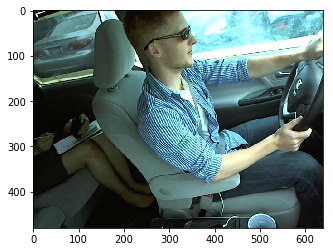

In [2]:
im = np.array(imageio.imread('./train/c0/img_100026.jpg'))
print('Image encoded using: ', im.dtype)
print('Image sizes are    : ', im.shape)
plt.imshow(im)

The .jpeg images are then composed of $480 \times 640 \times 3$ pixels. The thrird dimension stems from RGB color model. Each pixel is represented by an integer, uint8, coded on 8 bits (between 0 and 255). <br>
Besides, let us notice that the `./train/` folder is split into 10 subfolders `train/ci/` ($i \in [0,\,9]$) representing the 10 different driver's behaviors. These behaviors are displayed below:

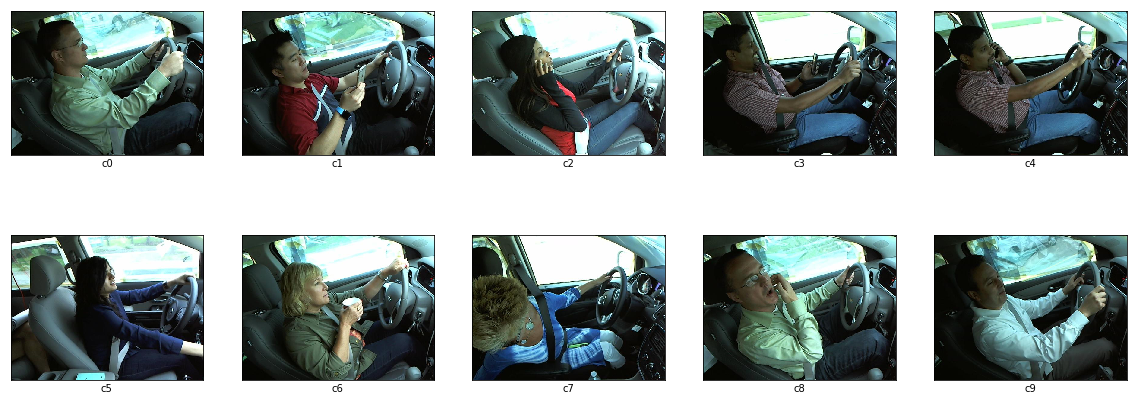

In [3]:
def Display_classes():
    
    """
    A simple function in order to display 10 pictures corresponding to the 10 different driver's behaviors.
    """
    plt.figure(figsize=(20,20))
    for i in range(10):
        
        #Path towards this class of images
        DIR = './train/c' + str(i) + '/'
        
        img_names = [f for f in os.listdir(DIR)]
        img       = np.array(imageio.imread(DIR + img_names[1]))

        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
        plt.xlabel('c'+str(i))
    plt.show()

Display_classes()

Labels associated with these 10 behaviors are the following:

    c0: safe driving
    c1: texting - right
    c2: talking on the phone - right
    c3: texting - left
    c4: talking on the phone - left
    c5: operating the radio
    c6: drinking
    c7: reaching behind
    c8: hair and makeup
    c9: talking to passenger


**About the size of the data sets to be created:** <br>
The above .jpeg images have a high resolution. Each of them has $480\times640\times3 = 9.216 \times 10 ^5$ pixels. If each pixel is encoded on 8 bits = 1 octet, this means that the weight of one single image is appproximately $0.9$ Mo. After normalization (division of all the pixel values by 255.0), the resulting array contains floating numbers encoded on 32 bits = 4 octets. Thus the size of this kind of array is $3.6$ Mo. <br>
My computer is endowed with $4$ Go of RAM. Hence the maximal number of samples $\text{m}_\max$ in a dataset directly stored in the RAM (neglecting the RAM used for other processes) is $4000/3.6 \approx 1.1 \times 10^3$. <br>
In practise $\text{m}_\max = 500$ is sufficient to paralyze my computer. If one whishes to preserve the total number of pixels by image, the data set must be stored on the computer hard disk. Besides, all the machine learning algorithms to be implemented need to systematically train _slices_ of data sets directly loaded from the hard disk. In the following, the high resolution framework is kept. Functions to tackle this difficulty are then presented.

The function `Create_Hdf5_Storage` is defined in order to store the huge floating number arrays of pixels in an **hdf5 file**. This file is stored on the hard disk and can be read and sliced in the notebook.

In [4]:
def Create_Hdf5_Storage(Info, minibatch_size= 10, stack_size=1):
    """
    ARGUMENTS:
    -Info  : Panda DataFrame containing informations about the different class frequencies
    OUTPUT:
    -The output is the hdf5 file "Data.hdf5" stored on the hard disk, it contains:
    -X_train, X_cv, X_test: np array of dimensions: (minibatch_size, NPix_H, NPix_W, 3)
        NPix_H = number of pixels along the vertical axis of the images
        NPux_W = number of pixels alons the horizontal axis of the images
        3      = three dimensions corresponding to RGB decomposition
    -Y_train, Y_cv, Y_test: np array of dimensions: (minibatch_size, 1)
        The label vector associated with the images
    """
   
    #Extracting some stats from the panda data framework 'Info':
    
    #Total number of images
    m_total = Info.shape[0]
    print('Total number of images: ', m_total)
    
    #Frequencies by type driver's behavior (10 classes)
    class_freq = Info['classname'].value_counts()
    
    print('Frequencies of the different classes of driver\'s behavior: \n')
    print(class_freq, '\n')
    
    #List of the different class labels
    class_labels = class_freq.index.values
    
    nb_class = len(class_labels)
    
    #Opening the hdf5 file in writting mode
    f = h5py.File("Data.hdf5", "w")


    #Pixel matrices
    X_train = f.create_dataset("X_train", (minibatch_size, 480, 640, 3), chunks=True, dtype='float32', compression="gzip")
    X_cv    = f.create_dataset("X_cv",    (minibatch_size, 480, 640, 3), chunks=True, dtype='float32', compression="gzip")
    X_test  = f.create_dataset("X_test",  (minibatch_size, 480, 640, 3), chunks=True, dtype='float32', compression="gzip")

    #Labels
    Y_train = f.create_dataset("Y_train", (minibatch_size, nb_class), chunks=True, dtype='i8', compression="gzip")
    Y_cv    = f.create_dataset("Y_cv",    (minibatch_size, nb_class), chunks=True, dtype='i8', compression="gzip")
    Y_test  = f.create_dataset("Y_test",  (minibatch_size, nb_class), chunks=True, dtype='i8', compression="gzip")

    #Number of samples for each class
    nb_samples_class = int(minibatch_size/nb_class)

    print('Data sets initialized in the hdf5 file \n')

    for i in range(nb_class):

        print('Opening class: ' + class_labels[i])

        #Path towards this class of images
        DIR = './train/' + class_labels[i] + '/'

        #Integer related to that class
        _, class_index = class_labels[i]
        class_index    = int(class_index)

        #Puting the names of jpeg images into a list
        #The names are shuffled to mix the different driver characters
        img_names = [f for f in os.listdir(DIR)]
        img_names = random.sample(img_names, len(img_names))

        #Lists in which jpeg images converted into arrays will be stored before being stacked to 
        #X_train, X_cv and X_test
        List_arrays_train, List_arrays_cv, List_arrays_test = [], [], []
        
        #Global indexes for the X_train, X_cv and X_test matrices
        ibegin = i*nb_samples_class
        iend   = i*nb_samples_class + stack_size
        stack_counter = 0

        for j in range(nb_samples_class):

            if(j!=0 and j%50==0):
                print('{}% treated'.format(j/nb_samples_class*100.0))

            img_train = np.array(imageio.imread(DIR + img_names[j]))/255. 
            img_cv    = np.array(imageio.imread(DIR + img_names[j + nb_samples_class]))/255.
            img_test  = np.array(imageio.imread(DIR + img_names[j + 2*nb_samples_class]))/255.

            #Punctually storing the np arrays into the lists before stacking it
            List_arrays_train.append(img_train)
            List_arrays_cv.append(img_cv)
            List_arrays_test.append(img_test)
            stack_counter += 1

            #Stacking procedure
            if(stack_counter==stack_size):                    
                X_train[ibegin:iend,:,:,:] = np.stack(List_arrays_train, axis=0)
                #print('X_train === ', X_train[ibegin:iend,200,200,:])
                X_cv[ibegin:iend,:,:,:]    = np.stack(List_arrays_cv, axis=0)
                X_test[ibegin:iend,:,:,:]  = np.stack(List_arrays_test, axis=0)
                ibegin = iend
                iend +=stack_size
                List_arrays_train, List_arrays_cv, List_arrays_test = [], [], []
                stack_counter = 0

        #Filling the label vectors Y_train, Y_cv, Y_test
        #One-Hot encoding 
        
        Hot_Label = np.repeat(np.eye(nb_class)[np.array([class_index]).reshape(-1)], nb_samples_class, axis=0)
        
        Y_train[i*nb_samples_class: (i+1)*nb_samples_class,:] = Hot_Label
        Y_cv[i*nb_samples_class: (i+1)*nb_samples_class,:]    = Hot_Label
        Y_test[i*nb_samples_class: (i+1)*nb_samples_class,:]  = Hot_Label
        
    #Closing the hdf5 file
    f.close()

We now can create our datasets. We start by small training, cross-validation and test sets of 500 examples. It represents approximately $2.5\%$ of the available labeled images stored in the `./train/` folder. Note that the 500 examples are partioned as 50 examples of each class of drivers. The label vectors `Y_train`,  `Y_cv` and `Y_test` are One-Hot encoded.  

In [5]:
Info = pd.read_csv("./driver_imgs_list.csv")
Create_Hdf5_Storage(Info, minibatch_size= 500, stack_size=25)

Total number of images:  22424
Frequencies of the different classes of driver's behavior: 

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64 

Data sets initialized in the hdf5 file 

Opening class: c0
Opening class: c3
Opening class: c4
Opening class: c6
Opening class: c2
Opening class: c5
Opening class: c1
Opening class: c9
Opening class: c7
Opening class: c8


We perform some basic checks in the new hdf5 file to be sure that we have correctly stored the data:

The shape of X_train is:  (100, 480, 640, 3)
The shape of Y_test  is:  (100, 10)
Y_cv is:  [1 0 0 0 0 0 0 0 0 0]


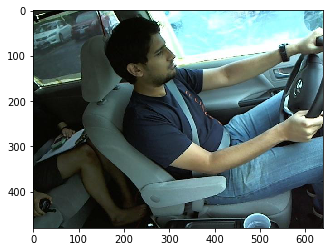

In [6]:
f = h5py.File("Data.hdf5", "r")
print('The shape of X_train is: ', f["X_train"].shape)
print('The shape of Y_test  is: ', f["Y_test"].shape)
img = f["X_train"][0,:,:,:]
plt.imshow(img)
print('Y_cv is: ',f["Y_cv"][9,:])
f.close()

## Part 2: Construction of a naive Convolutional Neural Network with **TensorFlow** ##

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to **Image Recognition**. The idea is to learn the best _filters_ of pixels in order to detect the relevant patterns in the image that allow to classify it. More information can be found on CNN by reading the __[CNN Wikipedia article](https://en.wikipedia.org/wiki/Convolutional_neural_network)__. <br>

In the following, a naive CNN model is implemented using **TensorFlow**. It is directly inspired from the _Deep Learning Course 4: Convolutional Neural Networks_ taught by _Andrew Ng_ on __[Coursera](https://fr.coursera.org/learn/convolutional-neural-networks)__. The adjective _naive_ refers to the fact that this CNN is not very deep in the sense it has only **2 hidden layers** (if one considers that Convolution + Non-Linear activation + Max pooling represents 1 layer). On the contrary, cutting-edge CNNs published in the litterature can handle more than 100 hidden layers. What is more, the CNN architecture does not apply any _normalizations_ ($L^2$ constraints, dropouts..) on its trainable variables. Finally, the architecture of the CNN does not contain any advanced tools to fasten the convergence of the loss function towards its minimum. Apart from the choice of the _ReLu_ activation function, nothing is made to overcome the _vanishing/exploding gradients_ phenomena. <br>

However this naive CNN will give us a first idea on how well standard machine learning algorithms perform to learn patterns of high resolution images.

First of all we define placeholders that will be used by the tensorflow model. These placeholders are named `X` and `Y` and contain `float32` numbers. Recall that the datasets stored into `Data.hdf5`.

In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0), name="X")
    Y = tf.placeholder(tf.float32, shape=(None,n_y), name="Y")
    
    return X, Y

In [8]:
X, Y = create_placeholders(480, 640, 3, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 480, 640, 3), dtype=float32)
Y = Tensor("Y:0", shape=(?, 10), dtype=float32)


Then we define a function to initialize the trainable weights of the naive convolutional neural network. For that purpose we use the __[Xavier's initializer](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi)__ which garantees that the variance of each layer of neurons is initially the same. 

In [9]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    #CHECK
    tf.set_random_seed(1)                           
        
    W1 = tf.get_variable("W1",[4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

The forward propagation function is now defined. The naive architecture of the convolutional neural network is:
     - Conv2D:   Use a 4 by 4 filter size and a 1 by 1 stride, padding is "SAME" --> 8 filters
     - ReLU
     - Max pool: Use a 8 by 8 filter size and a 8 by 8 stride, padding is "SAME" --> 8 filters
     - Conv2D:   Use a 2 by 2 filter size and a 1 by 1 stride, padding is "SAME" --> 16 filters
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME" --> 16 filters
     - Flatten the previous output.
     - Fully Connected (FC) layer: resulting in 10 neurons in the output layer, which then get passed later to a softmax. 
     
Remark: in TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost. <br>
Remark: in the above simple architecture, padding flag is always set to `SAME` which means that no reduction of the tensor size will occur from one layer to the other. Then accross the differente layers the CNN will conserve a very large number of neurons which can make it potentially slow regarding the number of operations to be done at each epoch. <br>
Remark: the total number of weights to be trained is $4^2\times3\times8 + 2^2\times8\times16 + 480\times640\times16\times 10 \approx 49.1$ millions. This important number of parameters (LeNet and AlexNet CNN have approximately 60 millions of parameters to train) is mainly due to the last fully connected layer and the fact that the same padding is applied accross the CNN layers. 

In [10]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 10 neurons in output layer. 
    Z3 = tf.contrib.layers.fully_connected(P2, 10, activation_fn=None)

    return Z3

The cost function to be minimized is introduced. For this classification problem with 10 classes, the loss is given the **multi-class cross entropy**. The expression of such a loss stems from the maximum likelyhood principle.

In [11]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y),0)
    
    return cost

**Definition of the naive model** <br>

Our naive model is now introduced. It will read slices of `X_train` stored in the `Data_hdf5` file. The number of examples by slice is given by `minibatch_size`. For each epoch, the CNN performs frontpropagation and backpropagation `floor(m/minibatch_size)` times; where `m` is the total number of samples stored in `Data_hdf5`. In the end, the loss and the accuracy (the proportion of good predictions among the overall data set) with respect to the training set and the test set are displayed.

In [12]:
def model(Data_hdf5, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    Data_hdf5 -- the hdf5 file create previously containing:
        X_train -- training set, of shape (500, 480, 640, 3)
        Y_train -- test set, of shape (500, n_y = 10)
        X_cv    -- cross-validation set, of shape (500, 480, 640, 3)
        Y_cv    -- cross-validation set, of shape (500, n_y = 10)
        X_test  -- test set, of shape (500, 480, 640, 3)
        Y_test  -- test set, of shape (500, n_y = 10)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    
    #Extracting the initial dimensions
    f = h5py.File(Data_hdf5, "r")
    (m, n_H0, n_W0, n_C0) = f["X_train"].shape             
    n_y = f["Y_train"].shape[1]  
    
    # To keep track of the cost
    costs = []
    test_costs = []
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # At the end of the session we will save the trained weights 
    saver = tf.train.Saver() 
    
    #CPU performance, use the maximal number of threads for the session operations
    config = tf.ConfigProto()
    
    #On my machine: 4 CPUs, with 2 Cores, 2 threads per socket = 16 threads 
    config.intra_op_parallelism_threads = 16

    #Saving start time (measuring the wall-clock time of the Session())
    start_time = time.time()
    
    # Start the session to compute the tensorflow graph
    with tf.Session(config=config) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # number of minibatches of size minibatch_size in the train set
        num_minibatches = int(m / minibatch_size)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost      = 0.
            test_minibatch_cost = 0.
            seed = seed + 1
            
            # number of mini batches of size mini_batch_size in your partitionning
            num_minibatches = math.floor(m/minibatch_size) 
            
            #Permutation over all the training example indexes
            perm        = list(np.random.permutation(m))
            minibatches = [sorted(perm[k * minibatch_size : (k+1) * minibatch_size]) for k in range(0, num_minibatches)]
            
            minibatch_counter = 1
            
            for minibatch in minibatches:
                
                minibatch_counter +=1
                if(minibatch_counter%100==0):
                    print('minibatches: {}% treated'.format(100.*minibatch_counter/minibatch_size))
                
                minibatch_X = f["X_train"][minibatch,:,:,:]
                minibatch_Y = f["Y_train"][minibatch,:]

                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost =sess.run([optimizer,cost], {X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
                test_temp_cost =sess.run(cost, {X: f["X_test"][minibatch,:,:,:], Y: f["Y_test"][minibatch,:]})
                test_minibatch_cost += test_temp_cost / num_minibatches
            
            # Handling the end case (last mini-batch < mini_batch_size)
            if m % minibatch_size != 0:
                minibatch_X = f["X_train"][sorted(perm[num_minibatches * minibatch_size : m]),:,:,:]
                minibatch_Y = f["Y_train"][sorted(perm[num_minibatches * minibatch_size : m]),:]

                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost =sess.run([optimizer,cost], {X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
                test_temp_cost =sess.run([cost], {X: f["X_test"][minibatch,:,:,:], Y: f["Y_test"][minibatch,:]})
                test_minibatch_cost += test_temp_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 2 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                test_costs.append(test_minibatch_cost)
        
        #Saving the trained weights into the folder data_W
        saver.save(sess, './model')
        
        # plot the cost
        plt.plot(np.squeeze(costs), color="red", label="training set")
        plt.plot(np.squeeze(test_costs), color="blue", label="test set")
        plt.ylabel('cross-entropy loss')
        plt.xlabel('epoch')
        plt.title("Learning rate =" + str(learning_rate))
        plt.legend()
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        true_pr_op = tf.argmax(Y, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        #Evaluate accuracy by loading blocks of input matrices with minibatch_size examples
        perm        = list(range(m))
        minibatches = [perm[k * minibatch_size : (k+1) * minibatch_size] for k in range(0, num_minibatches)]

        train_accuracy = 0.
        test_accuracy  = 0.
        
        for minibatch in minibatches:
            
            temp_train_accuracy = accuracy.eval({X: f["X_train"][minibatch,:,:,:], Y: f["Y_train"][minibatch,:]})
            temp_test_accuracy  = accuracy.eval({X: f["X_test"][minibatch,:,:,:], Y: f["Y_test"][minibatch,:]})

            train_accuracy += temp_train_accuracy
            test_accuracy  += temp_test_accuracy 

        # Handling the end case (last mini-batch < mini_batch_size)
        if m % minibatch_size != 0:
            temp_train_accuracy = accuracy.eval({X: f["X_train"][num_minibatches * minibatch_size : m,:,:,:],\
                                                 Y: f["Y_train"][num_minibatches * minibatch_size : m,:]})
            temp_test_accuracy  = accuracy.eval({X: f["X_test"][num_minibatches * minibatch_size : m,:,:,:],\
                                                 Y: f["Y_test"][num_minibatches * minibatch_size : m,:]})

            train_accuracy += temp_train_accuracy
            test_accuracy  += temp_test_accuracy

        #Re-scaling the accuracy    
        train_accuracy *= minibatch_size/m*1.
        test_accuracy  *= minibatch_size/m*1.
        
        #Randomly picking an image in the test data set and displaying its prediction and its true label
        img_index = randint(0, m)
        prediction = predict_op.eval({X: f["X_test"][img_index:img_index+1,:,:,:],Y: f["Y_test"][img_index:img_index+1,:]})
        true_label = true_pr_op.eval({X: f["X_test"][img_index:img_index+1,:,:,:],Y: f["Y_test"][img_index:img_index+1,:]})        
        
        plt.imshow(f["X_test"][img_index,:,:,:])
        if prediction == true_label:
            color = 'blue'
        else:
            color = 'red'
  
        class_names = ['c0','c1', 'c2','c3', 'c4','c5', 'c6','c7', 'c8', 'c9']
        plt.xlabel("predicted: {}, true label:  {}".format(class_names[prediction[0]],
                                class_names[true_label[0]]),
                                color=color)

    print('Running time of the session: {0:.2f} minutes'.format((time.time() - start_time)/60.))    
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
                
    return train_accuracy, test_accuracy

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 2.934388
Cost after epoch 2: 2.259544
Cost after epoch 4: 2.173745
Cost after epoch 6: 1.644973
Cost after epoch 8: 0.699311
Cost after epoch 10: 0.181388
Cost after epoch 12: 0.043894
Cost after epoch 14: 0.123315


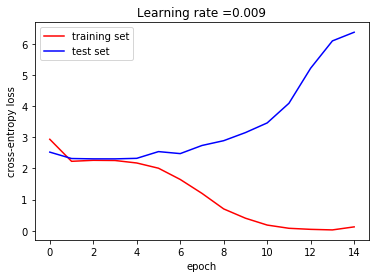

Running time of the session: 19.38 minutes
Train Accuracy: 0.989999994635582
Test Accuracy: 0.26999999955296516


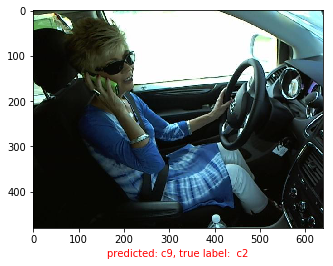

In [13]:
train_accuracy, test_accuracy = model('Data.hdf5', learning_rate = 0.009, num_epochs = 15, minibatch_size = 25, print_cost = True)

The results of this naive approach are not satisfying. The main drawback is the size of the high resolution images that entails huge tensors and makes the computational cost of the above CNN very important. Besides, after 15 epochs, one observes a gap between the cross-entropy loss of the training set and the one of the test set. Indeed, while the loss related to the training set decreases, the one of the test continues to fluctuate and does not seem to start its convergence. As a result, the above CNN might suffer from _overfitting_. 

Many ideas could be tested to improve the results. First of all one could remove the `SAME` padding flag so that to progressively reduce the tensor sizes when going deeper in the neural network. The second idea could be to reduce the size of the input tensor by extracting the main _principal components_ of the input training set. Such idea is quickly explored in the following.

## Part 3: Dimension reduction: an Iterative Principal Component Analysis method ##

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors (each being a linear combination of the variables) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables. More information can be found in the __[Wikipedia PCA article](https://en.wikipedia.org/wiki/Principal_component_analysis)__. <br>

In this section we will try to use PCA in order to extract the most important _combination of pixels_ (the principal components, also referred to as principal vectors) that are responsible for most of the variance of the training set. Once found, the idea is to project our data sets on these vectors and apply our CNN architecture to the new resulting input whose dimension is considerably reduced. <br>

However, it has to be known that for a dataset made of $m$ examples and $p$ features, the maximal number of principal components that can be extracted is equal to:<br>
>    $\min\left(m-1,\,p \right)$

In our case, `m=minibatch_size` the size of the slice of the data sets stored in the hdf5 file; `p=921600` the total number of pixels for one .jpeg image. Thus the maximal number of components that one will be able to extract is `minibatch_size-1`$\ll$ `p`. <br>

Before applying the PCA algorithm, we first need to flatten and to whiten (transform data so that it has zero-mean and unit-variance) our training sets. This is done in the following.

In [14]:
def Flatten_Hdf5(Data_hdf5, minibatch_size= 10):
    """
    A function that read X_train stored in the file Data_hdf5 and creates its flattened version.
    This new version is stored in "Data_Flattened.hdf5"
    """
    
    #Opening the hdf5 file in reading mode    
    f = h5py.File(Data_hdf5, "r")
    
    (m, n_H0, n_W0, n_C0) = f["X_train"].shape              
    
    #Opening the hdf5 file in writting mode
    f_flat = h5py.File("Data_Flattened.hdf5", "w")

    #Flattened Pixel matrices
    X_train_flat = f_flat.create_dataset("X_train_flat", (m, n_H0*n_W0*n_C0), chunks=True, dtype='float32', compression="gzip")

    #Number of steps
    nb_steps = math.floor(m/minibatch_size)
    
    for i in range(nb_steps):
        
        X_train_flat[i*minibatch_size:(i+1)*minibatch_size,:] = \
        (f["X_train"][i*minibatch_size:(i+1)*minibatch_size,:,:,:]*255.).reshape((minibatch_size,n_H0*n_W0*n_C0))

    #Closing file
    f.close()
    f_flat.close()



Flatten_Hdf5("Data.hdf5", minibatch_size =50)

f      = h5py.File("Data.hdf5", "r")
f_flat = h5py.File("Data_Flattened.hdf5", "r")
print("Shape of X_train_flat: ", f_flat["X_train_flat"].shape)
print("Shape of X_train: ", f["X_train"].shape)
f_flat.close()
f.close()

Shape of X_train_flat:  (100, 921600)
Shape of X_train:  (100, 480, 640, 3)


In [15]:
def White_Flat_Hdf5(Data_flat_hdf5, minibatch_size= 10):
    """
    A function that read X_train_flat stored in Data_flat_hdf5 and white it (zero mean, unit variance)
    """
    
    #Opening the hdf5 file in reading and writting mode    
    f_flat = h5py.File(Data_flat_hdf5, "r+")
    
    (m, n_features) = f_flat["X_train_flat"].shape             
        
    nb_steps = math.floor(m/minibatch_size)
    
    #Introducing the sklearn-scaler object 
    scaler = StandardScaler()
    
    #Estimating the mean and the standard deviation using minibatches and the "partial_fit" function
    for i in range(nb_steps):
        scaler.partial_fit(f_flat["X_train_flat"][i*minibatch_size:(i+1)*minibatch_size,:])

    #Standardizing the minibatches with the "partial_fit" mean and standard deviation estimations    
    for i in range(nb_steps):
        f_flat["X_train_flat"][i*minibatch_size:(i+1)*minibatch_size,:] = \
        scaler.transform(f_flat["X_train_flat"][i*minibatch_size:(i+1)*minibatch_size,:])
    
    f_flat.close()

White_Flat_Hdf5("Data_Flattened.hdf5", minibatch_size= 50)

The following function implements an iterative version of the PCA algorithm. At the end of it, the cumulative variance associated witg the set of principal components found is display as a function of the number of components.

In [16]:
def Incremental_PCA(Data_flat_standard_hdf5, minibatch_size= 25, n_components= 24):
    
    #Opening the hdf5 file in reading and writting mode    
    f_flat = h5py.File(Data_flat_standard_hdf5, "r+")
    
    (m, n_features) = f_flat["X_train_flat"].shape             
        
    nb_steps = math.floor(m/minibatch_size)
    
    #Introducing the sklearn-scaler object 
    ipca = IncrementalPCA(n_components=n_components, whiten=False, copy=False, batch_size=10)
    
    #Iterative PCA over the minibatches
    for i in range(nb_steps):
        ipca.partial_fit(f_flat["X_train_flat"][i*minibatch_size:(i+1)*minibatch_size,:])

    f_flat.close()
    
    plt.plot(np.cumsum(ipca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')

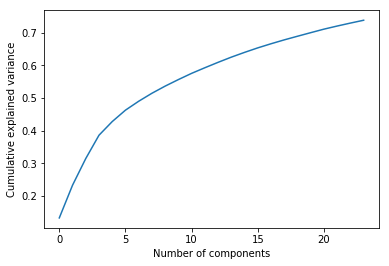

In [17]:
Incremental_PCA("Data_Flattened.hdf5", minibatch_size= 25, n_components= 24)

It turns out that in practice, `Incremental_PCA` returns a memory error (related to the call of the Lapack Single Value Decomposition algorithm) when `minibatch_size` is bigger than 25. In the above figure one can observe that the first 24 principal components are responsible of 70% of the variance of the training set. In the litterature PCA methods are considered to be sufficiently close to the initial data sets when they manage to catch at least 90% of the initial variance. That is why, we have decided to discard this method and focus on a more pragmatic one. 

### Image resize  using the **pillow** package ###

The idea here is to simply reduce the number of pixels of the original .jpeg images while preserving its aspect ratio. This is done thanks to the following function. 

In [18]:
def Image_Resize(image, width = None, height = None, inter = None):
    """
    A function that resize an image preserving its original aspect ration
    ARGUMENTS:
        -image: the input image
        -width: the new number of pixels along the horizontal axis
        -height: the new number of pixels along the vertical axis
        -inter: string referring to the type of interpolation in order to maintain the aspect of the original image
    OUTPUT:
        -resized: the image that has been resized
    """
    
    # Initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # Check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # Otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Resize the image
    resized =  np.array(Image.fromarray(image).resize(dim, Image.BICUBIC))
        
    # return the resized image
    return resized

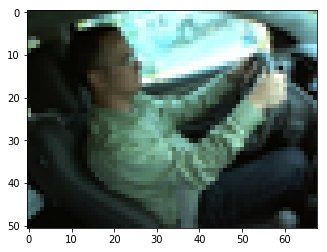

In [19]:
DIR = './train/c0/'
img_names = [f for f in os.listdir(DIR)]
img       = imageio.imread(DIR + img_names[1])
img.shape
plt.imshow(img)

img_resized = Image_Resize(img, width = 68, height = None, inter = None)
img_resized.shape

plt.imshow(img_resized)

The following function creates a new hdf5 file storing the resized .jpeg images.

In [20]:
def Create_Hdf5_Storage_Resized(Info, minibatch_size= 10, stack_size=1, width = None, height = None, inter = None):
    """
    ARGUMENTS:
    -Info  : Panda DataFrame containing informations about the different class frequencies
    -minibatch_size : the number of examples built in the data sets
    -stack_size : the number of images stored in a list before being copied inside the hdf5 file
    -width, height : the number pixels for the width (or the height) of the resized images
    -inter : interpolation method to preserve image aspect
    OUTPUT:
    -The output is the hdf5 file "Data.hdf5" stored on the hard disk, it contains:
    -X_train, X_cv, X_test: np array of dimensions: (minibatch_size, NPix_H, NPix_W, 3)
        NPix_H = RESIZED number of pixels along the vertical axis of the images
        NPix_W = RESIZED number of pixels alons the horizontal axis of the images
        3      = three dimensions corresponding to RGB decomposition
    -Y_train, Y_cv, Y_test: np array of dimensions: (minibatch_size, 10)
        The label vector associated with the images
        "10" corresponds to the ten different classes
    """
   
    #Extracting some stats from the panda data framework 'Info':
    
    #Total number of images
    m_total = Info.shape[0]
    print('Total number of images: ', m_total)
    
    #Frequencies by type driver's behavior (10 classes)
    class_freq = Info['classname'].value_counts()
    
    print('Frequencies of the different classes of driver\'s behavior: \n')
    print(class_freq, '\n')
    
    #List of the different class labels
    class_labels = class_freq.index.values
    
    nb_class = len(class_labels)
    
    #Opening the hdf5 file in writting mode
    f = h5py.File("Data_Resized.hdf5", "w")
    
    #Estimating the new numbers of pixels for the resized images
    DIR = './train/c0/'
    img_names = [f for f in os.listdir(DIR)]
    img       = imageio.imread(DIR + img_names[0])
    (n_pix_height, n_pix_width)  = img.shape[:2]
    
    # Check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(n_pix_height)
        dim = (int(n_pix_width * r), height)

    # Otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(n_pix_width)
        dim = (width, int(n_pix_height * r))

    #Resized pixel matrices
    X_train = f.create_dataset("X_train", (minibatch_size, dim[1], dim[0], 3), chunks=True, dtype='float32', compression="gzip")
    X_cv    = f.create_dataset("X_cv",    (minibatch_size, dim[1], dim[0], 3), chunks=True, dtype='float32', compression="gzip")
    X_test  = f.create_dataset("X_test",  (minibatch_size, dim[1], dim[0], 3), chunks=True, dtype='float32', compression="gzip")

    #Labels
    Y_train = f.create_dataset("Y_train", (minibatch_size, nb_class), chunks=True, dtype='i8', compression="gzip")
    Y_cv    = f.create_dataset("Y_cv",    (minibatch_size, nb_class), chunks=True, dtype='i8', compression="gzip")
    Y_test  = f.create_dataset("Y_test",  (minibatch_size, nb_class), chunks=True, dtype='i8', compression="gzip")

    #Number of samples for each class
    nb_samples_class = int(minibatch_size/nb_class)

    print('Data sets initialized in the hdf5 file \n')

    for i in range(nb_class):

        print('Opening class: ' + class_labels[i])

        #Path towards this class of images
        DIR = './train/' + class_labels[i] + '/'

        #Integer related to that class
        _, class_index = class_labels[i]
        class_index    = int(class_index)

        #Puting the names of jpeg images into a list
        #The names are shuffled to mix the different driver characters
        img_names = [f for f in os.listdir(DIR)]
        img_names = random.sample(img_names, len(img_names))

        #Lists in which jpeg images converted into arrays will be stored before being stacked to 
        #X_train, X_cv and X_test
        List_arrays_train, List_arrays_cv, List_arrays_test = [], [], []
        
        #Global indexes for the X_train, X_cv and X_test matrices
        ibegin = i*nb_samples_class
        iend   = i*nb_samples_class + stack_size
        stack_counter = 0

        for j in range(nb_samples_class):

            if(j!=0 and j%100==0):
                print('{}% treated'.format(j/nb_samples_class*100.0))

            img_train = np.array(Image_Resize(imageio.imread(DIR + img_names[j]), width = width, height = height, inter = inter))
            img_cv = np.array(Image_Resize(imageio.imread(DIR + img_names[j+ nb_samples_class]), width = width, height = height, inter = inter))
            img_test  = np.array(Image_Resize(imageio.imread(DIR + img_names[j+ 2*nb_samples_class]), width = width, height = height, inter = inter))

            #Punctually storing the np arrays into the lists before stacking it
            List_arrays_train.append(img_train)
            List_arrays_cv.append(img_cv)
            List_arrays_test.append(img_test)
            stack_counter += 1
            
            #Stacking procedure
            if(stack_counter==stack_size):
                
                X_train[ibegin:iend,:,:,:] = np.stack(List_arrays_train, axis=0)
                X_cv[ibegin:iend,:,:,:]    = np.stack(List_arrays_cv, axis=0)
                X_test[ibegin:iend,:,:,:]  = np.stack(List_arrays_test, axis=0)
                ibegin = iend
                iend +=stack_size
                List_arrays_train, List_arrays_cv, List_arrays_test = [], [], []
                stack_counter = 0

        #Filling the label vectors Y_train, Y_cv, Y_test
        #One-Hot encoding 
        
        Hot_Label = np.repeat(np.eye(nb_class)[np.array([class_index]).reshape(-1)], nb_samples_class, axis=0)
        
        Y_train[i*nb_samples_class: (i+1)*nb_samples_class,:] = Hot_Label
        Y_cv[i*nb_samples_class: (i+1)*nb_samples_class,:]    = Hot_Label
        Y_test[i*nb_samples_class: (i+1)*nb_samples_class,:]  = Hot_Label
        
    #Closing the hdf5 file
    f.close()

In [21]:
Create_Hdf5_Storage_Resized(Info, minibatch_size= 1000, stack_size=50, width = 64, height = None, inter = None)

Total number of images:  22424
Frequencies of the different classes of driver's behavior: 

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64 

Data sets initialized in the hdf5 file 

Opening class: c0
Opening class: c3
Opening class: c4
Opening class: c6
Opening class: c2
Opening class: c5
Opening class: c1
Opening class: c9
Opening class: c7
Opening class: c8


The shape of X_train is:  (1000, 48, 64, 3)
The shape of Y_test  is:  (1000, 10)
Y_cv is:  1


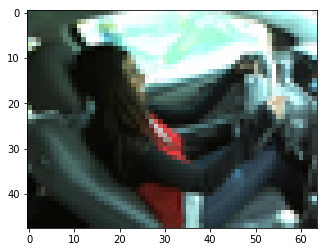

In [22]:
f = h5py.File("Data_Resized.hdf5", "r")
print('The shape of X_train is: ', f["X_train"].shape)
print('The shape of Y_test  is: ', f["Y_test"].shape)

img = f["X_train"][0,:,:,:]/255.
plt.imshow(img)
print('Y_cv is: ',f["Y_cv"][9,0])
f.close()

## Part 4: Construction of a deep Residual Network with **Keras** ##

We now have resized data sets and they can be directly loaded in RAM. Here, the objective is to implement a state-of-the-art deep learning CNN with **Keras**. The architecture retained is called **Residual Networks (ResNets)**. It stems from the following articles:
-  
    __[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)__

-   __[Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)__

The main idea is summarized in the figure below:

<img src="Resnets.png">

Let us define $x_l$ the tensor (or neurons) obtained in the $l$-th hidden layer. Define also $x_{l+1}$ the ouput of the next layer, after a serie of non-linear operations. Let us now concentrate on the left plot of the above figure and introduce $\mathbf{W}_1^{l+1}$ (respectively  $\mathbf{W}_2^{l+1})$ the trainable weights corresponding to the first (respectively the second) `weight` box. In the classical framework of CNNs, one can write:

> $x_{l+1} = g\left(\mathbf{W}_2^{l+1}\,g(\mathbf{W}_1^{l+1}\,x_{l}) \right)$

with $g\left(\right)$ the non-linear positive activation function. Here, we have omitted the Batch Normalization (`BN`) treatment. On the contrary, in residual networks, provided that the tensor dimensions are homogeneous, the construction of the layer $l+1$ writes:

> $x_{l+1} = g\left(\mathbf{W}_2^{l+1}\,g(\mathbf{W}_1^{l+1}\,x_{l}) + x_{l} \right)$

The idea is the following: suppose that at the end of layer $l$ the predictions obtained by the deep learning algorithm are optimal; then, for the next layer the deep learning neural network should learn an _identity mapping_ which will preserve the optimality of the predictions. It turns out that it is far more complex to fit an identity mapping with the purely non-linear expression

$g\left(\mathbf{W}_2^{l+1}\,g(\mathbf{W}_1^{l+1}\,x_{l}) \right)$,

than with 

$g\left(\mathbf{W}_2^{l+1}\,g(\mathbf{W}_1^{l+1}\,x_{l}) + x_{l} \right)$.

Indeed, thanks to the normalization constraint applied on $\mathbf{W}_1^{l+1}$ and $\mathbf{W}_2^{l+1}$, it is possible to force these weights to tend towards zero. Hence the above expression becomes:

$g\left(\mathbf{W}_2^{l+1}\,g(\mathbf{W}_1^{l+1}\,x_{l}) + x_{l} \right) \underset{\mathbf{W}^{l+1} \rightarrow 0}{=} g\left(x_{l}\right) $.

Noting that $x_{l}$ is positive, if $g() = \text{ReLu}()$, one obtains:

$x_{l+1}\underset{\mathbf{W}^{l+1} \rightarrow 0}{=} \text{ReLu}\left(x_{l}\right)=x_{l}$.

As mentioned by He et _al_ in __[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)__, in practice a degradation of the _training error_ is observed when the depth of CNN increases. Such a degradation  problem  suggests  that  the  solvers might have difficulties in approximating identity mappings by multiple nonlinear layers. With the above residual learning re-formulation, if identity mappings are optimal, the solvers may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings. <br>

In the sequel, we implement a 18-layers residual network following the structure proposed in __[Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)__. In order to do so we have imported and analyzed the developpements found in this __[Git Hub Repository](https://github.com/raghakot/keras-resnet)__ (MIT license). Let us mention that between 2D convolutions and Relu activations _Batch Normalizations_ are performed. Batch normalization refers to the article of Sergey Ioffe, Christian Szegedy: __[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)__. The idea is to systematically whiten (zero-mean and unit-variance) the new distribution of neurons obtained from the last layer. By doing so , one statistically prevents the neurons to take extreme values that are generally responsible for _vanishing gradients_ phenomena and that considerably damp the convergence of the algorithm. <br>

Let us first start by loading our data sets:


In [23]:
f = h5py.File("Data_Resized.hdf5", "r")
X_train = f["X_train"][:,:,:,:].astype('float32')
X_test  = f["X_test"][:,:,:,:].astype('float32')
Y_train = f["Y_train"][:,:]
Y_test  = f["Y_test"][:,:]
print('X_train shapes :', X_train.shape)
(m,nb_pix_height,nb_pix_width,nb_channels) = X_train.shape 
print('X_train_type = ', X_train.dtype)
f.close()

X_train shapes : (1000, 48, 64, 3)
X_train_type =  float32


Then, the data sets are whitened:

In [24]:
# subtract mean and standardize
mean_X = np.mean(X_train, axis=0)
std_X  = np.std(X_train, axis=0)
X_train -= mean_X
X_test -= mean_X
X_train /= std_X
X_test /= std_X

We define some parameters managing the convergence of the algorithm. We notably reduce the learning rate with `lr_reducer` if the training loss fluctuates to much.

In [25]:
input_shape = (nb_channels, nb_pix_height, nb_pix_width)
num_outputs = 10
batch_size = 32
nb_epoch = 50

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_driver.csv')

We finally build our 18-layer model:

In [26]:
Resnet_model = ResnetBuilder.build_resnet_18(input_shape, num_outputs)
Resnet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Res_History = Resnet_model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_data=(X_test, Y_test),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, csv_logger])

Train on 1000 samples, validate on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 65s 65ms/step - loss: 2.4733 - acc: 0.5080 - val_loss: 1.9684 - val_acc: 0.6710
Epoch 2/5
1000/1000 [==============================] - 65s 65ms/step - loss: 1.2775 - acc: 0.9100 - val_loss: 1.7828 - val_acc: 0.7350
Epoch 3/5
1000/1000 [==============================] - 62s 62ms/step - loss: 1.0463 - acc: 0.9620 - val_loss: 1.4823 - val_acc: 0.8130
Epoch 4/5
1000/1000 [==============================] - 62s 62ms/step - loss: 1.0025 - acc: 0.9600 - val_loss: 2.5403 - val_acc: 0.6420
Epoch 5/5
1000/1000 [==============================] - 58s 58ms/step - loss: 0.9474 - acc: 0.9720 - val_loss: 1.4791 - val_acc: 0.8110


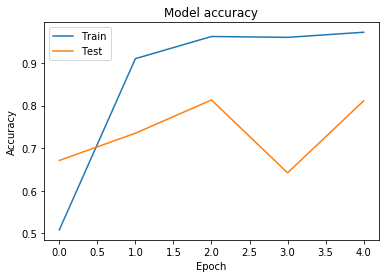

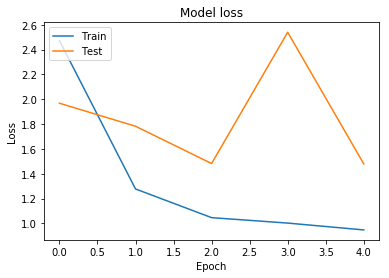

In [27]:
# Plot training & validation accuracy values
plt.plot(Res_History.history['acc'])
plt.plot(Res_History.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Res_History.history['loss'])
plt.plot(Res_History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()